# Introduction

In this project, we're going to build classifiers to detect sentiment in tweets.

In [ ]:
import re
import string
from random import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import twitter_samples

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

from tqdm import tqdm

# Data

Download the twitter sample data from NLTK repository.

* The `twitter_samples` contains 5,000 positive tweets and 5,000 negative tweets. Total count of 10,000 tweets.  
* We have the same no of data samples in each class.
* It is a balanced dataset.
* Tweets may have URLs, numbers, and special characters. Hence, we need to preprocess the text.

In [ ]:
nltk.download('twitter_samples')

In [ ]:
# read the positive and negative tweets
pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')
print(f"positive sentiment 👍 total samples {len(pos_tweets)} \nnegative sentiment 👎 total samples {len(neg_tweets)}")

In [ ]:
# Let's have a look at the data
no_of_tweets = 3
print(f"Let's take a look at first {no_of_tweets} sample tweets:\n")
print("Example of Positive tweets:")
print('\n'.join(pos_tweets[:no_of_tweets]))
print("\nExample of Negative tweets:")
print('\n'.join(neg_tweets[:no_of_tweets]))

Preprocessing is one of the important steps in the pipeline. It includes cleaning and removing unnecessary data before building a machine learning model.

Preprocessing steps:

* Tokenizing the string
   - Convert the tweet into lowercase and split the tweets into tokens(words)
* Removing stop words and punctuation
    - Will remove some strings commonly used on the twitter platform like the hashtag, retweet marks, hyperlinks, numbers and email address
* Stemming
    - This is the process of converting a word to it's most general form. This helps in reducing the size of our vocabulary. For example, the stemmed word `engag` will have the following different words,    
        - <strong>engag</strong>ement
        - <strong>engag</strong>ed
        - <strong>engag</strong>ing

Let's see how we can implement this.

In [ ]:
nltk.download('stopwords')

In [ ]:
class TweetProcessor():

    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    # get the english stopwords
    stopwords_en = stopwords.words('english')
    # get the english punctuation
    punctuation_en = string.punctuation
    # Instantiate stemmer object
    stemmer = PorterStemmer()

    @staticmethod
    def __remove_unwanted_characters__(tweet):
        # remove retweet style text "RT"
        tweet = re.sub(r'^RT[\s]+', '', tweet)
        # remove hyperlinks
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
        # remove hashtags
        tweet = re.sub(r'#', '', tweet)
        # remove email address
        tweet = re.sub(r'[\S]+@[\S]+', '', tweet)
        # remove numbers
        tweet = re.sub(r'\d+', '', tweet)
        # remove emojis
        tweet = re.sub(r':[\S]+', '', tweet)
        # remove non-alphanumeric characters
        tweet = re.sub(r'[^0-9a-zA-Z\s]+', '', tweet)
        # return removed text
        return tweet

    @staticmethod
    def __tokenize_tweet__(tweet):
        # tokenize tweets
        return TweetProcessor.tokenizer.tokenize(tweet)

    @staticmethod
    def __remove_stopwords__(tweet_tokens):
        # remove stopwords
        tweets_clean = []
        for word in tweet_tokens:
            if (word not in TweetProcessor.stopwords_en and  # remove stopwords
                word not in TweetProcessor.punctuation_en and  # remove punctuation
                len(word) > 1):  # remove single character words
                tweets_clean.append(word)
        return tweets_clean

    @staticmethod
    def __text_stemming__(tweet_tokens):
        # store the stemmed word
        tweets_stem = []
        for word in tweet_tokens:
            # stemming word
            stem_word = TweetProcessor.stemmer.stem(word)
            tweets_stem.append(stem_word)
        return tweets_stem

    @staticmethod
    def preprocess(tweets):
        tweets_processed = []
        for _, tweet in tqdm(enumerate(tweets)):
            # apply removing unwated characters and remove style of retweet, URL
            tweet = TweetProcessor.__remove_unwanted_characters__(tweet)
            # apply nltk tokenizer
            tweet_tokens = TweetProcessor.__tokenize_tweet__(tweet)
            # apply stop words removal
            tweet_clean = TweetProcessor.__remove_stopwords__(tweet_tokens)
            # apply stemmer
            tweet_stems = TweetProcessor.__text_stemming__(tweet_clean)
            # apply stop words removal
            words = TweetProcessor.__remove_stopwords__(tweet_stems)
            tweets_processed.extend([words])
        return tweets_processed

In [ ]:
# process the positive and negative tweets
processed_pos_tweets = TweetProcessor.preprocess(pos_tweets)
processed_neg_tweets = TweetProcessor.preprocess(neg_tweets)

Let’s take a look at what output got after preprocessing tweets.

In [ ]:
for i in range(no_of_tweets):
    print(pos_tweets[i])
    print(processed_pos_tweets[i])
    print()

Shuffle the corpus:

In [ ]:
# shuffle the positive and negative tweets
shuffle(processed_pos_tweets)
shuffle(processed_neg_tweets)

Create labels for the tweets:

In [ ]:
# 1 for positive labels and 0 for negative labels
positive_tweet_label = None  # TO-DO
negative_tweet_label = None  # TO-DO

Create the data frame:

In [ ]:
# combine the positive and negative tweets
twitter_processed_corpus = processed_pos_tweets + processed_neg_tweets
tweet_labels = positive_tweet_label + negative_tweet_label

In [ ]:
# create dataframe
tweet_df = pd.DataFrame(list(zip(twitter_processed_corpus, tweet_labels)), columns=["_tweet_", "_label_"])

In [ ]:
tweet_df.head()

Let's keep 80% of the data samples for training and 20% of the data samples for testing:

In [ ]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(tweet_df["_tweet_"], tweet_df["_label_"], test_size = 0.20, stratify=tweet_df["_label_"])

In [ ]:
# Combine the results into train and test dataframe
tweets_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
tweets_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [ ]:
print(len(tweets_train))
print(len(tweets_test))
tweets_train.head()

We have various methods to represent features for our Twitter corpus, which we'll use in the following sections. Some of the basic and powerful techniques are:

**1. CountVectorizer**

The count vectorizer indicates the sparse matrix and the value can be the frequency of the word. Each column is a unique token in our corpus.

The sparse matrix dimension would be `number of unique tokens in the corpus * number of sample tweets`.

Example: given the corpus:

```
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
 ]
```

a CountVectorizer representation could be:

```
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
```

**2. TF-IDF (Term Frequency - Inverse Document Frequence)**

TF-IDF statistical measure that evaluates how relevant a word is to a document in a collection of documents. TF-IDF is computed as follows:

$$ \text{tf-idf}(t, d, D) = \text{tf}(t,d) * \text{idf}(t,D) $$

*Term Frequency:* $\text{tf}(t,d)$

The simplest choice is to use the frequency of a term (word) in a document.

*Inverse Document Frequency:* $\text{idf}(t,D)$

It measures how much information the word provides, i.e., if it's common or rare across all documents. It is the **logarthmic scaled** of inverse fraction of the document that contain word. Definition is as per [Wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

# Naive Bayes Classifier

As Naive Bayes algorithm is a commonly used algorithm in machine learning task, we'll explain the key concepts and implement it from scratch. Later, we'll use `sklearn` built-in Naive Bayes classifier to compare the results.

## What is the multinomial Naive Bayes algorithm?

Naive Bayes algorithm is a probabilistic algorithm based on the famous "Bayes Theorem".

$P(c|x) = \frac{P(x|c) \:*\: P(c)}{P(x)}$, where

- P(c|x) is the posterior probability of class given predictor
- P(x|c) is the probability of predictor given class
- P(c) is the probability of class
- P(x) is the prior probability of predictor

When we know how frequent a class occurs (P(c)), how frequent a predictor occurs (P(x)) and the probability of a predictor given the class (P(x|c)), we can calculate how often a class occurs given the predictor (P(c|x)). A simple example of application is to infer the probability of a patient having a disease given a positive biomarker result - from the disease probability, positive biomarker probability and probability that a patient with the disease would have the positive biomarker.

In real-life machine learning problem, there are typically multiple predictors of a class instead of a single predictor x. Hence, the formula becomes more complicated considering the possible dependence between the predictors. Let's have a look at an example with 3 features.

$P(class | x_1,x_2,x_3) = \frac{P(class \:\cap\: (x_1, x_2, x_3))}{P(x_1, x_2, x_3)}$

$P(class | x_1,x_2,x_3) \propto P(class \!\cap\! x_1  \!\cap\! x_2  \!\cap\! x_3)$

$P(class | x_1,x_2,x_3) \propto P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class)$


Next, we can use the **multiplication rule of probability** to expand $P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class)$.

$P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class) = P(x_1 | x_2  \!\cap\! x_3 \!\cap\! class) \cdot P(x_2  \!\cap\! x_3 \!\cap\! class)$

$P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class) = P(x_1 | x_2  \!\cap\! x_3 \!\cap\! class) \cdot P(x_2 | x_3 \!\cap\! class) \cdot P(x_3 \!\cap\! class)$

$P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class) = P(x_1 | x_2  \!\cap\! x_3 \!\cap\! class) \cdot P(x_2 | x_3 \!\cap\! class) \cdot P(x_3 | class) \cdot P(class)$    

As you can see, the equation is getting pretty long for just three features. Imagine if we would like to train a spam classifier based on tens of thousands of texts, it would require a lot of calculations. This is where the Naive Bayes's assumption of **conditional independence between predictors** comes to rescue. With the assumption, the formula can be simplified to

$P(x_1 \!\cap\! x_2  \!\cap\! x_3 \!\cap\! class) = P(x_1 | class) \cdot P(x_2 | class) \cdot P(x_3 | class) \cdot P(class)$

Hence, the Naive Bayes algorithm can be summarized as:

$P(class | x_1,x_2,x_3) \propto P(x_1 | class) \cdot P(x_2 | class) \cdot P(x_3 | class) \cdot P(class)$

$P(class | x_1,x_2,x_3) \propto P(class) \cdot \prod_{i=1}^{3}P(x_i|class)$

It is good to note that the assumption of independence between predictors is unrealistic in practice. For example, certain words such as "happy", "fantastic" and "great" are more likely to appear together (i.e., dependent). As the assumption rarely holds in practice, the algorithm is called **Naive** Bayes.

Despite the simplifying assumption, Naive Bayes is an easy and fast model that works pretty well in many real-world problems. With the understanding of the algorithm, let's now implement it from scratch to classify tweets.

## Naive Bayes Model - from Scratch

Let's recall the formula of Naive Bayes algorithm.

$P(class | x_1,x_2,..., x_n) \propto P(class) \cdot \prod_{i=1}^{n}P(x_i|class)$

In order to calculate $P(x_i|class)$, we need to use the following equation.

$P(x_i|class) = \frac{N_{x_i|class} + \alpha}{N_{class} + \alpha \cdot N_{Vocabulary}}$
- $N_{x_i|class}$: total number of a word given the class
- $N_{class}$: total number of all the words in the class
- $N_{Vocabulary}$: total number of all the words in all classes
- $\alpha$: Laplace smoothing parameter. This is a non-zero parameter (usually set as 1) to tackle the zero probability problem in Naive Bayes algorithm. For instance, if a particular word did not appear in training set but appear in test set, $P(x'|class)$ would be zero, causing $P(class|x_1, x_2,..., x', ..., x_n)$ to be zero.

## Create the Vocabulary

Let's create the vocabulary, which includes all the unique words in the entire training dataset.

In [ ]:
vocab = []

for index, value in tweets_train['_tweet_'].items():
    for word in value:
        vocab.append(word)

# Transform vocab from list to set to remove duplicate words
vocab = list(set(vocab))

print("Number of vocabularies in the training set is {}".format(len(vocab)))

Next, we need to transform the training dataset to include columns of vocabularies and the occurrence of each vocabulary in each tweet. If we implement this using multiple for loops in Python, this step will take a very long time to run as we are trying to create a dataframe with a large number of columns (=number of vocabularies) and calculate the number of each vocab in each tweet. To solve this problem, let's use `sklearn` built-in `CountVectorizer` to help us.

In [ ]:
# For loops implementation - Did not run this step as it will take very long time to run
vocab_count_per_tweet = {word: [0] * len(tweets_train) for word in vocab}
for index, value in tweets_train['_tweet_'].items():
    for word in value:
        vocab_count_per_tweet[word][index] += 1

In [ ]:
vocab_counts = pd.DataFrame(vocab_count_per_tweet)
vocab_counts.head()

In [ ]:
# Combine all the tweets into a single list
corpus = tweets_train['_tweet_'].apply(lambda x:' '.join(x))

In [ ]:
# Fit CountVectorizer
vectorizer = CountVectorizer()
X_train_wc = vectorizer.fit_transform(corpus)
X_train_wc

From the output, we can see `X_train_wc` is a matrix with a shape which is equivalent to (number of tweets, number of vocabularies). Let's extract the feature names from the vectorizer and represent this using a dataframe.

In [ ]:
vocab_counts = pd.DataFrame(X_train_wc.toarray(), columns=vectorizer.vocabulary_.keys())

In [ ]:
# Concatenate vocab_counts with the original tweets_train dataframe
tweets_train = pd.concat([tweets_train, vocab_counts], axis=1)
tweets_train.head()

## Calculate Components of Naive Bayes Formula

Next, we can calculate the components to plug into the Naive Bayes formula. First, let's calculate the probability of tweets with positive sentiment and with negative sentiment in the training dataset.

In [ ]:
# P(positive) and P(negative)
p_positive = None  # TO-DO
p_negative = None  # TO-DO
print(p_positive, p_negative)

Next, let's calculate total number of words in each class. Then, we can calculate the conditional probability of occurrence of each word given the class and use them to predict the sentiment of a tweet

$P(x_i|class) = \frac{N_{x_i|class} + \alpha}{N_{class} + \alpha \cdot N_{Vocabulary}}$

In [ ]:
# Set smoothing parameter
alpha = 1

In [ ]:
# N_positive
n_positive = None  # TO-DO
n_positive

In [ ]:
# N_negative
n_negative = None  # TO-DO
n_negative

In [ ]:
# N_vocab
n_vocab = len(vocab)

In [ ]:
# Initialize dictionary to store conditional probability P(x|positive) and P(x|negative)
parameters_positive = {word:0 for word in vocab}
parameters_negative = {word:0 for word in vocab}

In [ ]:
# Calculate conditional probability
for word in vocab:
    parameters_positive[word] = None  # TO-DO
    parameters_negative[word] = None  # TO-DO

## Classifing Tweets

Now, we have all the components ready to build the classifier for sentiment analysis. The steps of sentiment analysis are:
- Take in a new tweet $(x_1, x_2, ..., x_n)$ as input
- Calculate $P(positive | x_1, x_2, ..., x_n)$ and $P(negative | x_1, x_2, ..., x_n)$
- Compare $P(positive | x_1, x_2, ..., x_n)$ and $P(negative | x_1, x_2, ..., x_n)$:
    * If $P(positive | x_1, x_2, ..., x_n)$ > $P(negative | x_1, x_2, ..., x_n)$, tweet is classified as positive sentiment
    * If $P(positive | x_1, x_2, ..., x_n)$ < $P(negative | x_1, x_2, ..., x_n)$, tweet is classified as negative sentiment
    

In [ ]:
def classify_new_tweet(tweet):

    p_positive_given_words = None  # TO-DO
    p_negative_given_words = None  # TO-DO

    if p_positive_given_words > p_negative_given_words:
        return 1
    else:
        return 0

We can now use this function to predict the sentiment of tweets in test set and evaluate the accuracy of our Naive Bayes model (built from scratch).  

Let's use the test set to test the performance of the model.

In [ ]:
tweets_test['_predicted_'] = tweets_test['_tweet_'].apply(classify_new_tweet)
tweets_test['_correct_'] = tweets_test['_label_'] == tweets_test['_predicted_']
tweets_test.head()

In [ ]:
# Print accuracy
tweets_test['_correct_'].value_counts(normalize=True)

Let's now take a look at how to train a Naive Bayes model using the `sklearn` library.

## Sklearn Naive Bayes Model

To train the multinomial Naive Bayes model, we need to have training and test set `X`, `y` in array-like format. Earlier on, we have used `sklearn` `CountVectorizer` to calculate `X_train_wc`, which can be fed into the model. Now, we just need to create 3 other variables: `X_test_wc`, `y_train` and `y_test`.

In [ ]:
# Convert y_train and y_test to array
y_train = np.array(tweets_train['_label_'])
y_test = np.array(tweets_test['_label_'])

# Create X_test_wc using sklearn CountVectorizer
corpus = tweets_test['_tweet_'].apply(lambda x:' '.join(x))
X_test_wc = vectorizer.transform(corpus)

# Ensure the shape of X, y in training and test set is correct
print("Shape of X_train: {}".format(X_train_wc.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test_wc.shape))
print("Shape of y_test: {}".format(y_test.shape))

Yes! Now we have all the components needed to train the Naive Bayes model and make prediction.

In [ ]:
clf = MultinomialNB() # default smoothing parameter alpha=1
clf.fit(X_train_wc, y_train)
clf.score(X_test_wc, y_test)

We can see that the accuracy of `sklearn` Naive Bayes model is very similar to the accuracy of our Naive Bayes model from scratch. This shows the steps we use to implement the algorithm from scratch is correct!

Instead of looking at just accuracy, `sklearn` also has other metrics such as confusion matrix and classification report for us to gain a deeper insights on how the model performs on the different classes. For instance, is the model doing well only in predicting the negative class but not the positive class? Let's take a look.

In [ ]:
# Generate confusion matrix plot
y_pred = clf.predict(X_test_wc)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Logistic Regression

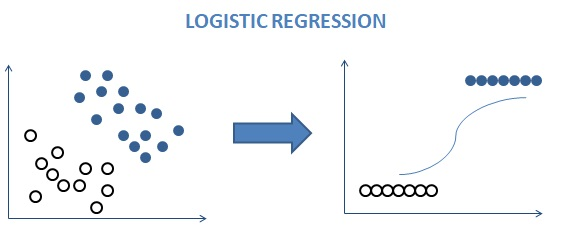

Our goal now is to implement logistic regression from scratch for sentiment analysis using the twitter dataset. We will be mainly focusing on building blocks of logistic regression on our own. This kernel can provide an in-depth understanding of <strong><i>how logistic regression works internally</i></strong>.

Given a tweet, it will be classified if it has <strong>positive sentiment 👍 or negative sentiment 👎</strong>.

## Feature Extraction

Given the text, It is very important to represent `features (numeric values)` such a way that we can feed into the model.

**Bag Of Words** (BOW) represents the word and its frequency for each class. We will create a `dict` for storing the frequency of  `positive` and `negative` classes for each word.Let’s indicate a `positive` tweet is `1` and the `negative` tweet is `0`.

The `dict` key is a tuple containing the `(word, y)` pair. The word is processed word and `y` indicates the label of the class. The `dict` value represents the frequency of the word for class `y`.

Example:

    # word good occurs 32 time in the 1.0 (positive) class
    {("good", 1.0) : 32}
    
    # word bad occurs 45 time in the 0 (negative) class
    {("bad", 0) : 45}



In [ ]:
# BOW frequency represent the (word, y) and frequency of y class
def build_bow_dict(tweets, labels):
    freq = {}
    ## create zip of tweets and labels
    for tweet, label in list(zip(tweets, labels)):
        for word in tweet:
            freq[(word, label)] = freq.get((word, label), 0) + 1

    return freq

In [ ]:
# build Bog of words frequency
bow_word_frequency = build_bow_dict(twitter_processed_corpus, tweet_labels)

Here, we won't be using `CountVectorizer` or `TF-IDF` to extract features. Instead, we are using a different set of features. Given a list of tweets, we will be extracting two features:

* The first feature is the number of positive words in a tweet.
* The second feature is the number of negative words in a tweet.
    
This seems to be simple, isn’t it? Perhaps yes.

In [ ]:
# extract feature for tweet
def extract_features(processed_tweet, bow_word_frequency):
    # feature array
    features = np.zeros((1,3))
    # bias term added in the 0th index
    features[0,0] = 1

    # iterate processed_tweet
    for word in processed_tweet:
        # get the positive frequency of the word
        features[0,1] = bow_word_frequency.get((word, 1), 0)
        # get the negative frequency of the word
        features[0,2] = bow_word_frequency.get((word, 0), 0)

    return features

In [ ]:
# train X feature dimension
train_X = np.zeros((len(tweets_train), 3))

for index, tweet in enumerate(tweets_train['_tweet_']):
    train_X[index, :] = extract_features(tweet, bow_word_frequency)

In [ ]:
# test X feature dimension
test_X = np.zeros((len(tweets_test), 3))

for index, tweet in enumerate(tweets_test['_tweet_']):
    test_X[index, :] = extract_features(tweet, bow_word_frequency)

In [ ]:
print(f"train_X {train_X.shape}, test_X {test_X.shape}")

Take a look at sample train features.
* Element at the 0th index is a bias term.
* Element at the 1st index is representing positive word frequency.
* Element at the 2nd index is representing negative word frequency.

In [ ]:
train_X[0:5]

## Implementation of Logistic Regression

Now, Let’s see how logistic regression works and gets implemented.

Most of the time, when you hear about logistic regression you may think, it is a regression problem. No, it is not, Logistic regression is a classification problem and it is a non-linear model.

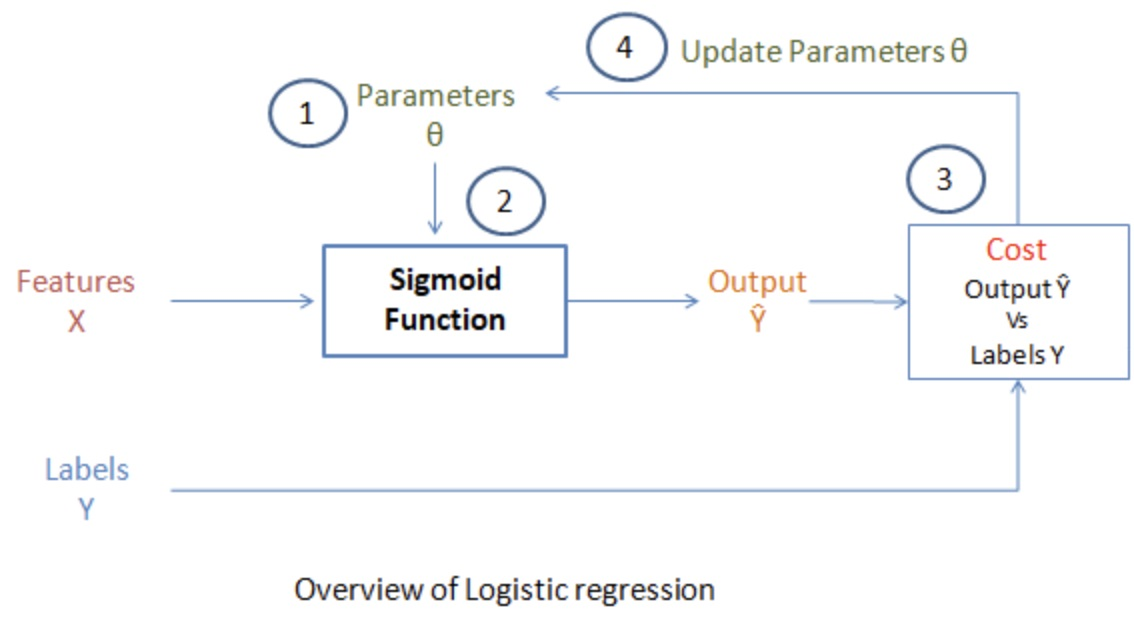

As shown in the above picture, there are 4 stages for most of the ML algorithms,
* Step 1. Initialize the weights
    - Random weights initialized
* Step 2. Apply function
    - Calculate the sigmoid
* Step 3. Calculate the cost (objective of the algorithm)
    - Calculate the log-loss for binary classification
* Step 4. Gradient Descent
    - Update the weights iteratively till finding the minimum cost

Logistic regression takes a linear regression and applies a <strong>sigmoid</strong> to the output of the linear regression. So, It produces the probability of each class and it sums up to 1.

<h6><strong>Regression:</strong></h6>
Single linear regression equation as follows:

$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N $$
* Note that the $\theta$ values are "weights"
* $x_0, x_1, x_2,... x_N$ is input features

You may think of how complicated equation it is. We need to multiply all the weigths with each feature at `ith` position then sums up all.

> Fortunately, <strong>Linear algebra</strong> brings this equation with ease of operation. Yes, It is a matrix `dot` product. You can apply the dot product of features and weights to find the $z$.
>
<h6><strong>Logistic regression:</strong></h6>
Applying the <strong>sigmoid</strong> function to equation $1$ becames <strong>logits</strong> function.

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

The sigmoid function is defined as:

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a <strong>probability</strong>.

In [ ]:
def sigmoid(z):
    return None  # TO-DO

The cost function used in logistic regression is:

$$ -\frac{1}{M}(ylog(p) - (1-y) log(1-p)) $$

This is the <strong>Log loss of binary classification.</strong> The average of the log loss across all training samples is calculated in logistic regression, the equation above modified for all the training samples as follows:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))$$

* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* When the model predicts 1 ($h(z(\theta)) = 1$) and the label $y$ is also 1, the loss for that training example is 0.
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0.
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [ ]:
def log_loss(h, y):
    return None  # TO-DO

Regularization is a technique to solve the problem of overfitting in a machine learning algorithm by penalizing the cost function. There will be an additional penalty term in the cost function.
There are two types of regularization techniques:

* Lasso (L1-norm) Regularization
* Ridge (L2-norm) Regularization

<strong>Lasso Regression (L1)</strong> L1-norm loss function is also known as least absolute errors (LAE). $λ*∑ |w| $ is a regularization term. It is a product of $λ$ regularization term with an absolute sum of weights. The smaller values indicate stronger regularization.

<strong>Ridge Regression (L2)</strong> L2-norm loss function is also known as least squares error (LSE). $λ*∑ (w)²$ is a regularization term. It is a product of $λ$ regularization term with the squared sum of weights. The smaller values indicate stronger regularization.

You could notice, is that makes a huge difference. Yes, it does well. The main difference is what type of regularization term you are adding in the cost function to minimize the error.

> L2 (Ridge) shrinks all the coefficient by the same proportions but it doesn't eliminate any features, while L1 (Lasso) can shrink some coefficients to zero, and also performs feature selection.

In [ ]:
def l2_regularizer(c, theta):
    return None  # TO-DO

Gradient Descent is a algorithm used for <strong> updating the weights $\theta$</strong> iteratively to minimize the objective function (cost). Why we need to update the weigths iteratively because,

> At initial random weights, model doesn't learn anything much. To imporve the prediction we need to learn the from the data with multiple iteration and tune the random weights accordingly.

The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.

In [ ]:
# implementation of gradient descent algorithm
def gradientDescent(x, y, theta, alpha, num_iters, c):

    # get the number of samples in the training
    m = x.shape[0]

    for i in range(0, num_iters):

        # TO-DO
        pass

        # find linear regression equation value, X and theta

        # get the sigmoid of z

        # calculate the cost function, log loss

        # let's add L2 regularization

        # update the weights theta

    return None

Let's now train the model

In [ ]:
# set the seed in numpy
np.random.seed(1)
# Apply gradient descent of logistic regression
# 0.1 as added L2 regularization term
J, theta = gradientDescent(train_X, np.array(y_train).reshape(-1,1), np.zeros((3, 1)), 1e-7, 1000, 0.1)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

## Test our logistic regression

It is time to test our logistic regression function on test data that model has not seen before.

Predict whether a tweet is positive or negative.

* Apply the sigmoid to the logits to get the prediction (a value between 0 and 1).

$$y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$$

In [ ]:
# predict for the features from learned theata values
def predict_tweet(x, theta):
    return None  # TO-DO

In [ ]:
# predict for the test sample with the learned weights for logistics regression
predicted_probs = predict_tweet(test_X, theta)
# assign the probability threshold to class
predicted_labels = np.where(predicted_probs > 0.5, 1, 0)
# calculate the accuracy
print(f"Own implementation of logistic regression accuracy is {len(predicted_labels[predicted_labels == np.array(y_test).reshape(-1,1)]) / len(y_test)*100:.2f}")

## Sklearn logistic regression

In [ ]:
# scikit learn logiticsregression and accuracy score metric
clf = LogisticRegression(random_state=42, penalty='l2')
_ = clf.fit(train_X, y_train)

In [ ]:
y_pred = clf.predict(test_X)
y_pred_probs = clf.predict(test_X)

In [ ]:
print(f"Scikit learn logistic regression accuracy is {accuracy_score(y_test , y_pred)*100:.2f}")

# Conclusion

Let's consider the differences between the two approaches:

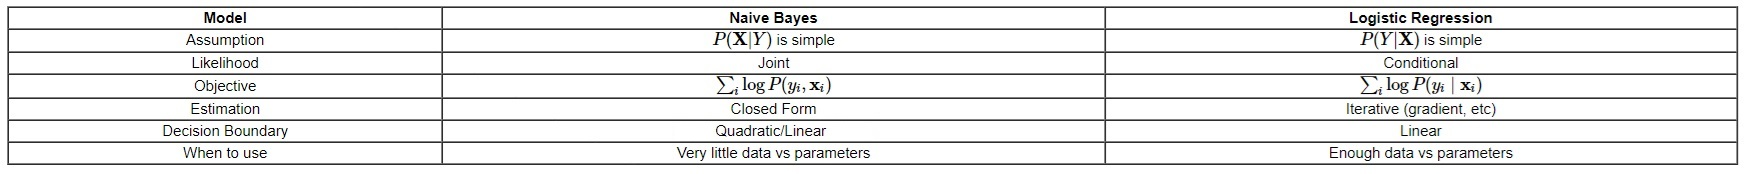